In [136]:
%reload_ext autoreload
%autoreload 2


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [137]:
import glob
import gzip
import json
import os
import spacy
import matplotlib
import numpy as np
from scipy import stats

from language import lang_code_map, spacy_model_map

lang_code_map

{'Arabic': 'ar',
 'Czech': 'cs',
 'Danish': 'da',
 'German': 'de',
 'Greek': 'el',
 'English': 'en',
 'Spanish': 'es',
 'Persian': 'fa',
 'Finnish': 'fi',
 'French': 'fr',
 'Hindi': 'hi',
 'Hungarian': 'hu',
 'Indonesian': 'id',
 'Italian': 'it',
 'Japanese': 'ja',
 'Korean': 'ko',
 'Dutch': 'nl',
 'Norwegian': 'no',
 'Polish': 'pl',
 'Pashto': 'ps',
 'Portuguese': 'pt',
 'Russian': 'ru',
 'Slovak': 'sk',
 'Slovenian': 'sl',
 'Serbian': 'sr',
 'Swedish': 'sv',
 'Turkish': 'tr',
 'Ukranian': 'uk',
 'Urdu': 'ur',
 'Chinese': 'zh'}

In [7]:
languages = [
    # Add languages for which you want to do linguistic parsing of reviews
    'English', 'Italian', 'Spanish', 'German'
]

lang_codes = [lang_code_map[language] for language in languages]
lang_codes

['en', 'it', 'es', 'de']

## Load the SpaCy models

You need these to either parse the review text yourself, or read the pre-parsed reviews from file.

In [8]:
from language import load_language_nlp_model

lang_nlp = {lang: load_language_nlp_model(lang) for lang in lang_codes}

# 1. Reading and inspecting book metadata

The book metadata that we scraped from Goodreads is stored in the file `book_metadata.csv'. Let's load that and see what fields (columns) the metadata contains.

In [14]:
import pandas as pd

book_meta_file = '../data/book_metadata.csv'
book_df = pd.read_csv(book_meta_file, sep='\t')
book_df.head(4)

,source_file,source_url,book_id,book_title,book_description,book_author,author_urls,genres,format,num_pages,publication_date,rating_avg,rating_count,review_count,canonical_url
0,../data/Canonical_book_pages/19288043-gone-gir...,https://www.goodreads.com/book/show/19288043-g...,19288043,Gone Girl,An alternative cover edition for this ISBN can...,['Gillian Flynn'],['https://www.goodreads.com/author/show/2383.G...,"['Fiction', 'Mystery', 'Thriller', 'Book Club'...",Paperback,415,2012-05-24T00:00:00,4.14,3396893,167501,https://www.goodreads.com/book/show/19288043-g...
1,../data/Canonical_book_pages/41865.Twilight.html,https://www.goodreads.com/book/show/41865.Twil...,41865,Twilight,About three things I was absolutely positive. ...,['Stephenie Meyer'],['https://www.goodreads.com/author/show/941441...,"['Fantasy', 'Young Adult', 'Romance', 'Fiction...",Paperback,498,2005-10-05T00:00:00,3.67,7204009,145791,https://www.goodreads.com/book/show/41865.Twil...
2,../data/Canonical_book_pages/35036409-my-brill...,https://www.goodreads.com/book/show/35036409-m...,35036409,My Brilliant Friend,Beginning in the 1950s in a poor but vibrant n...,"['Elena Ferrante', 'Ann Goldstein']",['https://www.goodreads.com/author/show/44085....,"['Fiction', 'Historical Fiction', 'Book Club',...",Paperback,331,2011-10-19T00:00:00,4.05,453131,44571,https://www.goodreads.com/book/show/35036409-m...
3,../data/Canonical_book_pages/15823480-anna-kar...,https://www.goodreads.com/book/show/15823480-a...,15823480,Anna Karenina,Acclaimed by many as the world's greatest nove...,"['Leo Tolstoy', 'Aylmer Maude', 'Louise Maude']",['https://www.goodreads.com/author/show/128382...,"['Classics', 'Fiction', 'Romance', 'Russia', '...",Paperback,964,1878-01-01T00:00:00,4.10,918097,41633,https://www.goodreads.com/book/show/15823480-a...


### Discussion questions
* Are there possible fields that you miss in the metadata?
* What potentially interesting questions would you not be able to answer with these metadata?
* Would there be other ways to obtain that data?

## Basic stats
Let's do some basic inspection of the metadata we have. Let's start with a histogram that tells us about how the number of times books get reviewed is distributed. 

array([[<Axes: title={'center': 'rating_count'}>]], dtype=object)

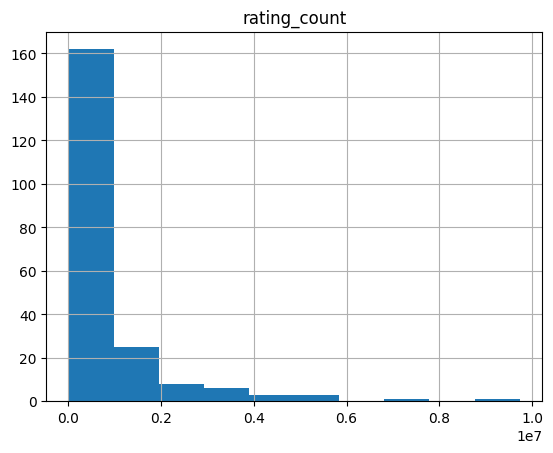

In [51]:
book_df.hist( column='rating_count', bins=10 )

Wow, those nubers are huge. What is the highest and lowest number of ratings?

In [52]:
print( 'max:', book_df['rating_count'].max() )
print( 'min:', book_df['rating_count'].min() )

max: 9730655
min: 15839


### Exercise
When dealing with huge numbers it is often more insightful to use a log scale. <br/>
Create a histogram based on the 10log of 'rating_count'. <br/>
Based on the histogram estimate what the most frequent number of times is that books receive a rating.

array([[<Axes: title={'center': 'log_rating_count'}>]], dtype=object)

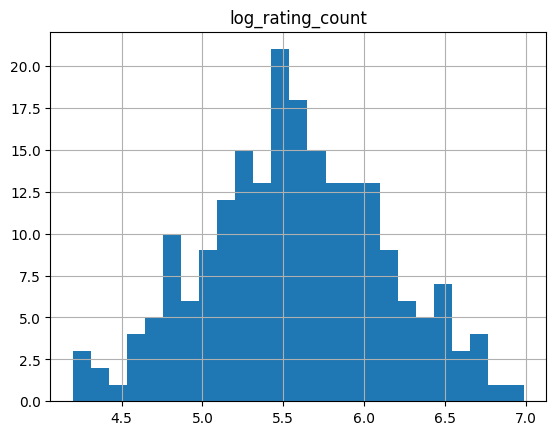

In [60]:
book_df['log_rating_count'] = np.log10(book_df['rating_count'])
book_df.hist( column='log_rating_count', bins=25 )

## Popularity vs rating

The number of ratings and reviews a book gets is probably a good proxy for its popularity. It is also not unimaginable that popularity relates to rating, in the sense that popular books may be rated higher than not so popular books.

To investigate this, let's first create a scatter plot of review counts versus the mean rating.

<Axes: xlabel='log_review_count', ylabel='rating_avg'>

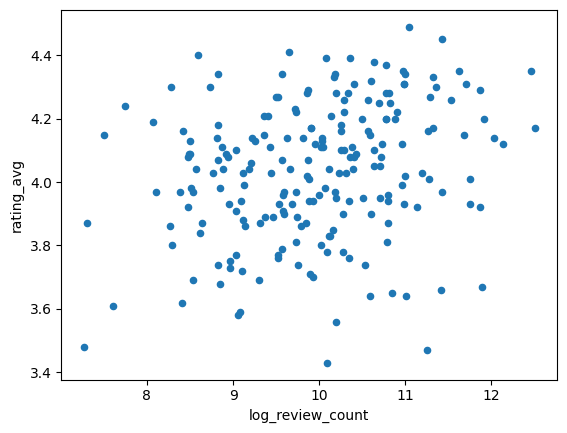

In [69]:
book_df['log_review_count'] = np.log(book_df['review_count'])
book_df.plot.scatter( x='log_review_count', y='rating_avg' )

That does not seem to give us much reason to suspect a strong relation between popularity and acverage rating. <br/>
But how can we know for sure? Let's try a linear regression.

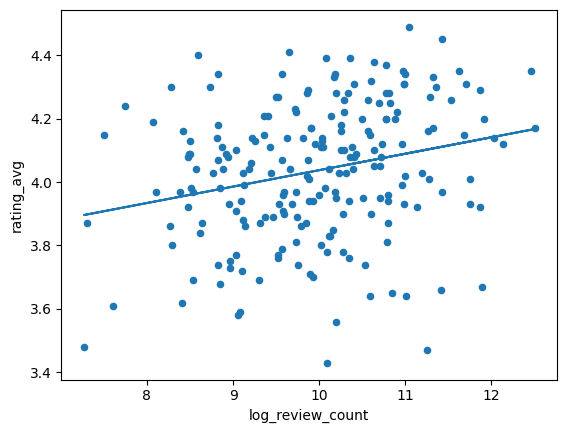

In [74]:
slope, intercept, pearson_r, p_value, std_err = stats.linregress( book_df['log_review_count'], book_df['rating_avg'] )

def lin_reg_func(x):
  return slope * x + intercept

lin_model = list( map( lin_reg_func, book_df['log_review_count'] ) )

ax = book_df.plot.scatter( x='log_review_count', y='rating_avg' )
ax.plot( book_df['log_review_count'], lin_model )


### Question
How do you evaluate the relation between review count and mean rating?

In [93]:
f'{pearson_r:.2f}'

'0.25'

# 2. Investigating review level metadata

The 'raw' reviews are in the `../data/lang_reviews` directory as `.gz` files. <br/>
We need a bit of file reading and data mangling to read in the review data for the chosen languages…

In [96]:
def read_reviews(review_file):
    with gzip.open(review_file, 'rt') as fh:
        return [json.loads(line) for line in fh]

review_dir = '../data/lang_reviews/'
review_files = glob.glob(os.path.join(review_dir, '*'))
review_file_map = {rf.split('lang_')[-1][:2]: rf for rf in review_files}
reviews = {}
for lang in lang_codes:
    reviews[lang] = read_reviews(review_file_map[lang])
    print(f"{len(reviews[lang])} reviews for language {lang}")

review_df = pd.DataFrame([review for lang in reviews for review in reviews[lang]])
review_df = pd.merge(review_df, book_df[['book_id', 'book_title', 'book_author']], on='book_id')

6270 reviews for language en
6128 reviews for language it
6254 reviews for language es
5825 reviews for language de


Let's see what the review data looks like…

In [98]:
review_df.head(2)

,review_text,user_id,review_id,review_date,shelf_status,user_shelves,rating,book_id,source_url,review_lang,book_title,book_author
0,"Oh, Emma. Emma, Emma, Emma. Darling, why must ...",4189f79d23c4bd1eac89950d91d80c5af9c51261eb6539...,33fd62c4107560c5153864c4394a7d9ea4120c76e9d41d...,2011-07-05T00:00:00,,"[19th-century, examined-lives, fiction]",4.0,2175,https://goodreads.com/en/book/show/2175.Madame...,en,Madame Bovary,"['Gustave Flaubert', 'Hans van Pinxteren']"
1,welcome to...MADAME BOVUARY! you know what tim...,a2e726dd7be2f50e9a00a9327f153af4676a8bb0f5f7f6...,46f530f863cad4fbda780805ae3360768ad3db4f3c0f2e...,2023-02-26T00:00:00,,"[3-and-a-half-stars, classics, gorgeous-covers]",3.0,2175,https://goodreads.com/en/book/show/2175.Madame...,en,Madame Bovary,"['Gustave Flaubert', 'Hans van Pinxteren']"


### Exercise 
We can also inspect individual reviews, using the code below.
Change and rerun the code several times to get an impression of reviews in different languages.

In [10]:
# show an example review
print(json.dumps(reviews['it'][0], indent=4))

{
    "review_text": "C'EST MOI   Meravigliosa come sempre, semplicemente perfetta, Isabelle Huppert nell\u2019adattamento del 1991 firmato da Claude Chabrol. Letto un paio di volte e sempre amato. Uno dei massimi capolavori della letteratura, secondo me. Flaubert \u00e8 uno dei sommi: me lo immagino di notte, solo nella sua casa di Rouen, che sono ovviamente stato a visitare, al lume di candela, che 'recita' le parole scritte, ancora e ancora, urlandole, cancellando, limando, riscrivendo, fino a trovare la formula giusta, quella perfetta. Le mot juste.  Perch\u00e9, lui \u00e8 con la perfezione che si misurava.  E alla perfezione si \u00e8 avvicinato, e, secondo me, la perfezione ha raggiunto. Realistico, il romanzo certamente lo \u00e8: non contiene nulla che non sia esistito nella vita reale (e facilissimo da riscontrare attraverso sopralluoghi e testimonianze); e anche se sbuffa ogni tanto \"nulla in questa storia \u00e8 tratto dalla vita, \u00e8 totalmente inventata\", non c'\u00e

### Question

You might be tempted to investigate the popularity of the same book in different languages by comparing review counts between languages. <br/>
The below code shows you why this data set is not adequat for such an approach. Can you explain why that is? <br/>
Can you think of a different approach that might be attempted with this data?

In [99]:
review_df.groupby(['book_id', 'book_title', 'book_author']).review_lang.value_counts().unstack().fillna(0.0)

,,review_lang,de,en,es,it
book_id,book_title,book_author,,,,
11,The Hitchhiker’s Guide to the Galaxy,['Douglas Adams'],30.0,30.0,30.0,30.0
93,Heidi,"['Johanna Spyri', 'Angelo Rinaldi', 'Beverly Cleary']",30.0,30.0,30.0,30.0
320,One Hundred Years of Solitude,"['Gabriel García Márquez', 'Gregory Rabassa']",30.0,30.0,30.0,30.0
343,العطر: قصة قاتل,"['Patrick Süskind', 'باتريك زوسكند', 'نبيل الحفار']",30.0,30.0,30.0,30.0
656,War and Peace,"['Leo Tolstoy', 'Aylmer Maude', 'Louise Maude']",30.0,30.0,30.0,30.0
...,...,...,...,...,...,...
61439040,1984,['George Orwell'],30.0,30.0,30.0,30.0
77265004,The Iliad,"['Homer', 'Robert Fagles', 'Bernard Knox']",30.0,30.0,30.0,30.0
127441416,The Diary of a Young Girl,"['Anne Frank', 'Eleanor Roosevelt', 'Susan Massotty']",30.0,30.0,30.0,30.0


In [129]:
def avg_rating_by_lang( book_id ):
    book_title = list( review_df[ review_df['book_id']==book_id ]['book_title'] )[0]
    print( f'{book_title}…' )
    for lang in [ 'en', 'de', 'it', 'es' ]:
        mean_rating = review_df[ review_df['review_lang']==lang ][ review_df['book_id']==book_id ]['rating'].mean()
        print( f'{lang}: {mean_rating:.3f}' )
    print( '---' )
    
avg_rating_by_lang( 320 )
avg_rating_by_lang( 11 )


One Hundred Years of Solitude…
en: 4.033
de: 3.464
it: 4.567
es: 4.700
---
The Hitchhiker’s Guide to the Galaxy…
en: 3.767
de: 3.833
it: 3.967
es: 3.800
---


### Exercise
The above observation might lead to the hypothesis that different languages (i.e. different culutres?) rate differently. <br/>
For instance: might Italians rate books higher on average than Germans? <br/>
Can you adapt the `groupby` statement above to generate a general average rating per language?


In [ ]:
review_df.groupby(['book_id', 'book_title', 'book_author']).review_lang.value_counts().unstack().fillna(0.0)

# review_df.groupby( [ 'review_lang' ] ).rating.mean()


### Question
Is there a significant difference between the languages? How would you evaluate?

# 3. Inspecting reviews

## Loading parsed reviews

It is possible to parse the texts of reviews, giving you POS tagging, lemmatization, syntactic information, etc. However the process takes quite some time. So, for the practical purpose of this workshop we are using pre-parsed data. We leave it as an exercise to the user to try out the various language parsers.

In [141]:
from analyse import read_from_doc_bins

parsed_dir = '../data/spacy_doc_bins/'
parsed_reviews = {}
for lang in lang_codes:
    parsed_file = os.path.join( parsed_dir, f"parsed_reviews-{lang}.doc_bin" )
    parsed_reviews[lang] = read_from_doc_bins( lang, parsed_dir, lang_nlp[lang].vocab )
    print( lang, len( parsed_reviews[lang] ) )

en 6270
it 6128
es 6254
de 5825


## Comparing stats by language
We have similar numbers of reviews per language. Use the code below to gauge if this means we also have comparable amounts of tokens and words too.

<Axes: >

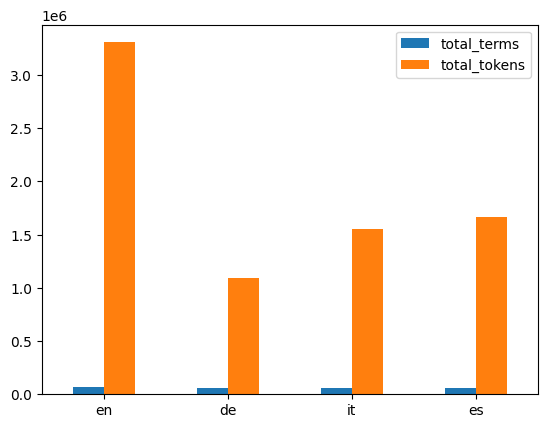

In [154]:
from collections import defaultdict, Counter

frequencies = { 
    'languages': [ 'en', 'de', 'it', 'es' ],
    'term_freq': [],
    'total_terms': [],
    'doc_freq': [],
    'total_tokens': []
}
    
for lang in frequencies['languages']:
    # the total frequency of words
    term_freq = Counter()
    # the document frequency of words, that is, in how many reviews does a word occur?
    doc_freq = Counter()
    # The total number of documents/reviews
    num_reviews = len(parsed_reviews[lang])
    
    for doc in parsed_reviews[lang]:
        # list all words in the review
        terms = [token.text for token in doc]
        # ignore case, turn all terms to lowercase
        terms = [term.lower() for term in terms]
        term_freq.update(terms)
        doc_freq.update(set(terms))

    frequencies['term_freq'].append( term_freq )
    frequencies['total_terms'].append( len( term_freq ) )
    frequencies['doc_freq'].append( doc_freq )
    frequencies['total_tokens'].append( sum( term_freq.values() ) )

frequencies_df = pd.DataFrame( frequencies, index=frequencies['languages'] )
frequencies_df.plot.bar( rot=0 )

### Question
What are some possible reasons for the differences you see?

## Most used words per language

<Figure size 640x480 with 0 Axes>

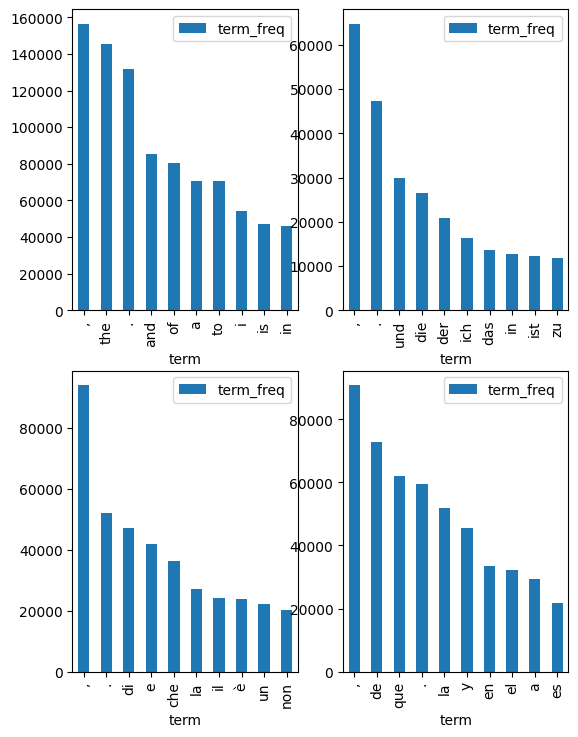

In [197]:
matplotlib.pyplot.tight_layout()
fig, axs = matplotlib.pyplot.subplots( 2, 2 )
matplotlib.pyplot.subplots_adjust( bottom=-0.5 )
axsl = [axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]
for idx, lang in enumerate( frequencies['languages'] ):
    mc_df = pd.DataFrame( frequencies['term_freq'][idx].most_common(10), columns=['term','term_freq'] )
    mc_df.plot.bar( x='term', y='term_freq', ax=axsl[idx] )

# A naive approach to comparing reviews across languages

We might have intuitions about how people express themselves when they are impressed by reading a particular book. Thus, if we want to quantify this we might approach that by thinking of some expressions, translating these in the target languages and finding matching reviews. <br/>
This is a naive approach as our intuitions might not match what is actually happening in the data, but it is a informative first step towards a more exhaustive methof of analysis. <br/>
Let's start from the word “fantastic” in English, which we surmise to be present in highly excited reviews. It translates to “fantastisch” in German, “fantastico” in Italian, and “fantástico” in Spanish.

In [203]:
review_df.head(2)

,review_text,user_id,review_id,review_date,shelf_status,user_shelves,rating,book_id,source_url,review_lang,book_title,book_author
0,"Oh, Emma. Emma, Emma, Emma. Darling, why must ...",4189f79d23c4bd1eac89950d91d80c5af9c51261eb6539...,33fd62c4107560c5153864c4394a7d9ea4120c76e9d41d...,2011-07-05T00:00:00,,"[19th-century, examined-lives, fiction]",4.0,2175,https://goodreads.com/en/book/show/2175.Madame...,en,Madame Bovary,"['Gustave Flaubert', 'Hans van Pinxteren']"
1,welcome to...MADAME BOVUARY! you know what tim...,a2e726dd7be2f50e9a00a9327f153af4676a8bb0f5f7f6...,46f530f863cad4fbda780805ae3360768ad3db4f3c0f2e...,2023-02-26T00:00:00,,"[3-and-a-half-stars, classics, gorgeous-covers]",3.0,2175,https://goodreads.com/en/book/show/2175.Madame...,en,Madame Bovary,"['Gustave Flaubert', 'Hans van Pinxteren']"


<Axes: xlabel='review_lang'>

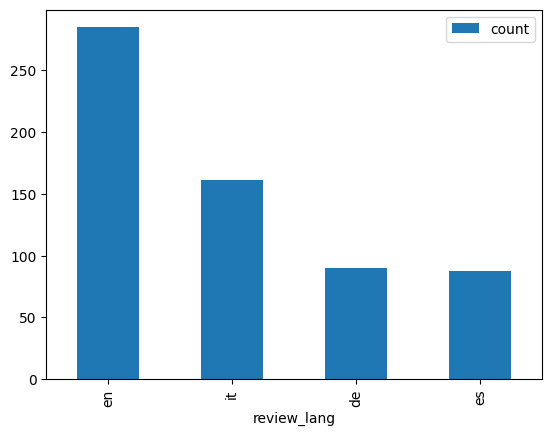

In [220]:
terms = [ 'fantastic', 'fantastico', 'fantastisch', 'fantástico' ]
fanta_df = review_df[ review_df['review_text'].apply( lambda rev_txt: any( term in rev_txt for term in terms ) ) ]
pd.DataFrame( fanta_df['review_lang'].value_counts() ).plot.bar()


### Discussion question
It is clear that English speaking people are much more prone to be excited about books, right? ;-) <br/>
This approach to analyzing impact terms across languages is certainly flawed (hence 'naive'). Discuss confounding factors that might skew